# Import Libraries

In [104]:
import numpy as np 
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , RepeatedStratifiedKFold , cross_val_score , RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix , f1_score ,roc_auc_score ,classification_report , roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# Preprocessing & Importing DataSet

In [105]:
new = pd.read_csv('Customer_Scor3yr (1).csv')
new1 = pd.read_csv('Customer_Scor3yr (2).csv')

In [106]:
dataset = pd.concat([new,new1],axis = 0)
dataset['RepDate_end'] = pd.to_datetime(dataset['RepDate_end'] , format = '%Y%m%d')
train_data = dataset.loc[dataset['Train_test1'] == 1]
test_data = dataset.loc[dataset['Train_test1'] == 0]
train_data.drop(columns = ['Train_test1','customer'],axis = 1,inplace = True)
test_data.drop(columns = ['Train_test1','customer'],axis = 1,inplace = True)

In [107]:
dataset = dataset.reset_index(False,drop = True)
dataset.head(10)

,customer,RepDate_end,will_default,WOE_max_dpd_3,WOE_avg_arr_6_avg_bal_6,WOE_mnths_snc_dpd_gt_60,WOE_avg_bal_1_avg_bal_3,WOE_avg_bal_1_3_avg_bal_4_6,WOE_age,Scores,Train_test1
0,1018,2021-02-28,0,1.35,1.34,0,0.94,-0.28,0.05,745.79,0.0
1,1018,2019-04-30,0,1.35,1.34,0,-0.12,-0.28,0.05,723.00,0.0
2,1018,2020-12-31,0,1.35,1.34,0,-0.12,-0.28,0.05,723.00,0.0
3,1018,2019-01-31,0,1.35,1.34,0,-0.12,-0.28,0.05,723.00,0.0
4,1018,2018-07-31,0,1.35,1.34,0,0.94,-0.28,0.05,745.79,0.0
5,1018,2018-11-30,0,1.35,1.34,0,-0.12,-0.28,0.05,723.00,0.0
6,1018,2020-06-30,0,1.35,1.34,0,0.94,0.74,0.05,768.47,0.0
7,1018,2019-08-31,0,1.35,1.34,0,-0.12,0.74,0.05,745.68,0.0
8,1018,2020-02-29,0,1.35,1.34,0,-0.12,0.74,0.05,745.68,0.0
9,1018,2018-08-31,0,1.35,1.34,0,-0.12,-0.28,0.05,723.00,0.0


# 2.Calculate Gini for Train and Test Sample

In [108]:
def X_train_X_test(train,test):
    y_train = train['will_default']
    train_predict = train['Scores']
    
    y_test = test['will_default']
    test_predict = test['Scores']

    train_gini = -(roc_auc_score(y_train,train_predict)*2 - 1)
    test_gini = -(roc_auc_score(y_test,test_predict)*2 - 1)

    Gini_Data_Frame = pd.DataFrame({'Train':train_gini,'Test':test_gini},index = ['Gini'])
    return Gini_Data_Frame
X_train_X_test(train_data, test_data)
#Train and test sample input 

,Train,Test
Gini,0.761516,0.766358


# 3.Calculate Gini over time for each month on Full sample

In [109]:
def gini_over_month(df,date,target,score):
    dict = {}
    sorted_date =  sorted(df[date].unique())
    sorted_date.pop(-1)
    scores = []
    df = df[[date,target,score]]
    for i in sorted_date: 
        
        
        dict[i] = [x for x in df.loc[df[date] == i].index]
        
        
        clon = pd.DataFrame(data = df , index = dict[i][0:])
        y_train = clon[target]
        y_pred = clon[score]
        roc_auc = roc_auc_score(y_train,y_pred)
        GINI = -(roc_auc*2 - 1)
        scores.append(GINI)
    
    result = pd.DataFrame({'Date':sorted_date,'Gini':scores})
    return result
gini_over_month(dataset,'RepDate_end','will_default','Scores')
#Input Date , target , Scores

,Date,Gini
0,2018-05-31,0.786822
1,2018-06-30,0.775812
2,2018-07-31,0.780730
3,2018-08-31,0.787330
4,2018-09-30,0.772554
5,2018-10-31,0.779745
6,2018-11-30,0.792208
7,2018-12-31,0.796941
8,2019-01-31,0.787235
9,2019-02-28,0.785368


# 4. Calculate Gini for each WOE characteristic on Train and Test samples

In [118]:
def Gini_for_charact(train,test,target):
    train = train.drop(['RepDate_end','Scores'],axis = 1)
    test = test.drop(['RepDate_end','Scores'],axis = 1)
    list = [train,test]
    scores = []
    for i in list:
        for g in i.columns[1:]: 
            gini = (roc_auc_score(i.iloc[:,0].values,-i[g])*2 - 1)
            scores.append(gini)
    train_scores = scores[0:6]
    test_scores = scores[6:]
    summary = pd.DataFrame({'Woe_Characteristics':train.columns.values[1:] , 'Train_Gini':train_scores , 'Test_Gini': test_scores})
    return summary
Gini_for_charact(train_data,test_data,'will_default')
# Input train and test sample + target

,Woe_Characteristics,Train_Gini,Test_Gini
0,WOE_max_dpd_3,0.652636,0.653836
1,WOE_avg_arr_6_avg_bal_6,0.658784,0.662246
2,WOE_mnths_snc_dpd_gt_60,0.000000,0.000000
3,WOE_avg_bal_1_avg_bal_3,0.309779,0.334905
4,WOE_avg_bal_1_3_avg_bal_4_6,0.165685,0.188067
5,WOE_age,0.039656,0.028975


# 5. Calculate Gini for each WOE characteristic over time for each month on Full sample

In [111]:
def Gini_for_charact(df,date):
    woe = df.drop(['Scores','Train_test1','customer'],axis = 1)
    train = pd.DataFrame(data = woe,columns = woe.columns.values)
    sorted_date = sorted(df[date].unique())
    sorted_date.pop(-1)  #Delete last month from sample to avoid error 
    dict = {}
    summary1 = pd.DataFrame()
    for i in sorted_date: 
        scores = []
        dict[i] = [x for x in df.loc[df[date] == i].index]
        clon = pd.DataFrame(data = train , index = dict[i][0:])
        

        for g in clon.columns[2:]:
            gini = (roc_auc_score(clon.iloc[:,1].values,-clon[g])*2 - 1)
            scores.append(gini)
            summary = pd.DataFrame()
            summary = pd.DataFrame(columns = [i] , data = scores )
    
        
        summary1 = pd.concat([summary1,summary],axis = 1)
    summary1.insert(0,'Characteristics',woe.columns.values[2:])
        
    return summary1
Gini_for_charact(dataset,'RepDate_end')
# Input all dataset and date

,Characteristics,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00,2019-01-31 00:00:00,2019-02-28 00:00:00,2019-03-31 00:00:00,2019-04-30 00:00:00,2019-05-31 00:00:00,2019-06-30 00:00:00,2019-07-31 00:00:00,2019-08-31 00:00:00,2019-09-30 00:00:00,2019-10-31 00:00:00,2019-11-30 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00
0,WOE_max_dpd_3,0.692529,0.682283,0.691765,0.697464,0.688365,0.714268,0.725469,0.715069,0.723978,0.696962,0.688388,0.657162,0.682010,0.684910,0.683797,0.675136,0.612230,0.600684,0.603491,0.611583,0.618326,0.616586,0.592885,0.483368,0.309037,0.099489,0.750518,0.827997,0.797070,0.793731,0.800549,0.830860,0.915420,0.957501,0.961416
1,WOE_avg_arr_6_avg_bal_6,0.704110,0.696876,0.692319,0.690754,0.684875,0.698454,0.707657,0.699661,0.678901,0.681545,0.683368,0.667943,0.652869,0.662317,0.661402,0.655758,0.609984,0.595257,0.595583,0.604923,0.587872,0.600313,0.647224,0.669378,0.648580,0.679547,0.738943,0.766513,0.743600,0.785958,0.790764,0.830054,0.880901,0.912422,0.930855
2,WOE_mnths_snc_dpd_gt_60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,WOE_avg_bal_1_avg_bal_3,0.313255,0.297587,0.296195,0.312616,0.307492,0.275793,0.277284,0.318025,0.312349,0.307743,0.321378,0.279738,0.273641,0.266980,0.269740,0.264514,0.239742,0.251896,0.266880,0.269687,0.294151,0.340540,0.356602,0.472561,0.546789,0.593434,0.547017,0.503405,0.362038,0.400783,0.456838,0.467218,0.544015,0.589634,0.675493
4,WOE_avg_bal_1_3_avg_bal_4_6,0.211184,0.209663,0.187250,0.174995,0.174960,0.166429,0.175761,0.162181,0.168632,0.186540,0.181975,0.199954,0.180580,0.169587,0.154824,0.138213,0.131525,0.137184,0.138386,0.145917,0.168231,0.181644,0.187973,0.209514,0.223776,0.259929,0.283234,0.295502,0.263665,0.239775,0.229815,0.221922,0.249600,0.254389,0.267977
5,WOE_age,0.030673,0.029090,0.025798,0.030546,0.036049,0.040135,0.037893,0.051826,0.058094,0.065108,0.060558,0.064961,0.057026,0.058576,0.057647,0.054416,0.056287,0.054795,0.054259,0.052407,0.051348,0.056987,0.056010,0.059031,0.061121,0.070672,0.104809,0.118097,0.090719,0.089754,0.098752,0.106028,0.092291,0.102928,0.092142


# 6. Based on the Train sample define the intervals for 10 score groups 
(the interval width is defined as (max(score)-min(score))/10 so that we have, for instance 0-100, 100-200 … 900-1000) - reference intervals and reference shares

In [112]:
def intervals(score_intervals,score,date,target):
    
    intervals = pd.cut(score_intervals[score],10)
    score_intervals = pd.concat([intervals, score_intervals.loc[:,[date,score,target]]],axis = 1)
    score_intervals.columns = ['Intervals','RepDate_end','Scores','will_default']
    score_intervals = score_intervals.reindex(columns=['RepDate_end', 'Scores', 'Intervals', 'will_default'])
    
    return score_intervals

intervals(dataset,'Scores','RepDate_end','will_default')
# Input all dataset , scores , date and target 

,RepDate_end,Scores,Intervals,will_default
0,2021-02-28,745.79,"(728.693, 768.47]",0
1,2019-04-30,723.00,"(688.916, 728.693]",0
2,2020-12-31,723.00,"(688.916, 728.693]",0
3,2019-01-31,723.00,"(688.916, 728.693]",0
4,2018-07-31,745.79,"(728.693, 768.47]",0
...,...,...,...,...
1606848,2021-04-30,768.47,"(728.693, 768.47]",0
1606849,2021-04-30,737.60,"(728.693, 768.47]",0
1606850,2021-04-30,473.29,"(450.254, 490.031]",0
1606851,2021-04-30,723.00,"(688.916, 728.693]",0


# (No number). Dashboard distribution 

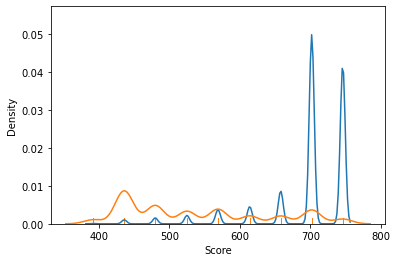

<Figure size 1152x648 with 0 Axes>

In [122]:
def dashboard(df,min1,max1,cut):
    dist = dataset[['Scores','will_default']]
    dist.columns = ['Score','Status']
    dist['Score'] = round(dist['Score'])
    list = [int(x) for x in np.linspace(min1,max1,cut)]
    for i in range(len(list)):
        if i < cut-1:
                a = (list[i]+list[i+1])/2
                dist.loc[dist['Score'].isin(range(list[i],list[i+1])),'Score'] = a
                i = i + 1
                 
    dist['Score'] = round(dist['Score'],0)
    
    unique_vals = dist['Status'].unique()  
    targets = [dist.loc[dist['Status'] == val] for val in unique_vals]
    
    for target in targets:
        sns.distplot(target[['Score']], hist=False, rug=True)
    plt.ylabel('Density')
    plt.xlabel('Score')
    
    plt.figure(figsize=(16,9))
    
 
dashboard(dataset,370,769,10) 
# Input dataset , minimal score , maximal score and how many intervals do we need 

# 7. Calculate PSI over time for each month on Full sample using reference intervals and reference shares (SCORE)

In [130]:
def psi_score(dataset,date):
    frame = dataset[['Scores','RepDate_end']]
    dict = {}
    sorted_date =  sorted(frame[date].unique())
    complete = pd.DataFrame()
    list = [int(x) for x in np.linspace(370,769,11)]
    for i in sorted_date: 
    
        
        dict[i] = [x for x in frame.loc[frame[date] == i].index]
        actual = pd.DataFrame(data = frame , index = dict[i][0:])
        clon = [x for x in sorted_date if x is not i]
        old = frame.loc[frame[date].isin(clon)]
        
        
        for f in range(len(list)):
            if f < 10:
                actual[f] = np.where((actual['Scores'] >= list[f] ) & (actual['Scores'] < list[f+1]), 1, 0)
                old[f] = np.where((old['Scores'] >= list[f] ) & (old['Scores'] < list[f+1]), 1, 0)
                f = f + 1

        old.columns = ['Scores','RepDate_end','Interval:1','Interval:2','Interval:3','Interval:4','Interval:5','Interval:6','Interval:7','Interval:8','Interval:9','Interval:10']
        actual.columns = ['Scores','RepDate_end','Interval:1','Interval:2','Interval:3','Interval:4','Interval:5','Interval:6','Interval:7','Interval:8','Interval:9','Interval:10']

        old = old.drop(['Scores','RepDate_end'],axis = 1)
        actual = actual.drop(['Scores','RepDate_end'],axis = 1)
        
        PSI_calc_train = old.sum() / old.shape[0]
        PSI_calc_new =   actual.sum()/ actual.shape[0]
        
        PSI = pd.concat([PSI_calc_train,PSI_calc_new],axis = 1)
        PSI = PSI.reset_index()
        PSI.columns = ['index', 'Proportions_Train', 'Proportions_New']
        
        PSI['Original_name'] = PSI['index'].str.split(':').str[0]
        PSI = PSI[np.array(['index', 'Original_name', 'Proportions_Train', 'Proportions_New'])]
        PSI = PSI[(PSI['index'] != 'Intercept')]

        PSI['Contribution'] = np.where((PSI['Proportions_Train'] == 0) | (PSI['Proportions_New'] == 0),
                                       0, (PSI['Proportions_New'] - PSI['Proportions_Train']) * np.log(PSI['Proportions_New'] / PSI['Proportions_Train'])) 
        PSI_summary = PSI.groupby('Original_name')['Contribution'].sum()
        

        variables = PSI_summary.tolist()
        indexes = PSI_summary.index.tolist()
        
        
        df2 = pd.DataFrame([variables],columns=indexes)
        
        new_row = {}
        
        for num,p in enumerate(indexes):
                   
                new_row[p] = variables[num]
        
        complete = complete.append(new_row,ignore_index = True)
    complete.insert(0,'Date',sorted_date)
    complete.columns = ['Date','PSI_score']
    return complete
psi_score(dataset,'RepDate_end')
# Input all dataset and date 

,Date,PSI_score
0,2018-05-31,0.022435
1,2018-06-30,0.022726
2,2018-07-31,0.019435
3,2018-08-31,0.018163
4,2018-09-30,0.014667
5,2018-10-31,0.018960
6,2018-11-30,0.020766
7,2018-12-31,0.023423
8,2019-01-31,0.028274
9,2019-02-28,0.030646


# 8. Calculate PSI for WOE variables over time for each month on Full sample using Train sample as reference

In [116]:
def PSI_m(woe_frame,date):
    woe_frame = pd.concat([woe_frame[date],woe_frame.iloc[:,3:9]],axis = 1)
    dict = {}
    sorted_date =  sorted(woe_frame[date].unique())
    complete = pd.DataFrame()
    for i in sorted_date: 
    
        dict[i] = [x for x in woe_frame.loc[woe_frame[date] == i].index]
        actual = pd.DataFrame(data = woe_frame.iloc[:,1:] , index = dict[i][0:])
        clon = [x for x in sorted_date if x is not i]
        old = woe_frame.loc[woe_frame[date].isin(clon)]
        old = old.drop('RepDate_end',axis = 1)
        list = []
        for h in old.columns:
            
            
            d = pd.DataFrame({'Old': [x/old.shape[0] for x in old[h].value_counts().tolist()] , 'Actual': [x/actual.shape[0] for x in actual[h].value_counts().tolist()] })
            PSI = ((d['Old']-d['Actual']) * np.log(d['Old']/d['Actual'])).sum()
            list.append(PSI)
        
       
        variables = list
        indexes = woe_frame.columns.tolist()[1:]
        
       
        df2 = pd.DataFrame([variables],columns=indexes)
        
        new_row = {}
        
        for num,p in enumerate(indexes):
                   
                new_row[p] = variables[num]
        
        complete = complete.append(new_row,ignore_index = True)
    complete.insert(0,'Date',sorted_date)
    
    complete.columns = [x.replace('WOE_','') for x in complete.columns]

    return complete
PSI_m(dataset,'RepDate_end')
# Input all dataset and date 

,Date,age,avg_arr_6_avg_bal_6,avg_bal_1_3_avg_bal_4_6,avg_bal_1_avg_bal_3,max_dpd_3,mnths_snc_dpd_gt_60
0,2018-05-31,2.259737e-03,0.023769,4.300051e-05,0.003040,0.000683,0.0
1,2018-06-30,1.831214e-03,0.021760,6.292369e-05,0.007371,0.000682,0.0
2,2018-07-31,1.716010e-03,0.018490,1.092871e-04,0.010924,0.000134,0.0
3,2018-08-31,1.830450e-03,0.017623,9.441272e-05,0.007559,0.000188,0.0
4,2018-09-30,1.921338e-03,0.013625,1.465315e-05,0.008610,0.000145,0.0
5,2018-10-31,1.676332e-03,0.017967,8.452360e-06,0.010963,0.000105,0.0
6,2018-11-30,1.623059e-03,0.021829,1.891712e-05,0.013444,0.000381,0.0
7,2018-12-31,1.697683e-03,0.024073,7.805533e-04,0.018693,0.001815,0.0
8,2019-01-31,1.662855e-03,0.029053,2.187688e-03,0.020995,0.001814,0.0
9,2019-02-28,1.415973e-03,0.030901,4.614109e-03,0.019339,0.004174,0.0


# 9. Calculate HHI over time for each month on Full sample using reference intervals and reference shares 

In [120]:
def HHI(df,min1,max1,cut,var):
    hhi = dataset.loc[:,['RepDate_end','Scores']]
    list = [int(x) for x in np.linspace(min1,max1,cut)]
    hhi['New_Score'] = 0
    for i in range(len(list)):
            if i < cut-1:
                a = (list[i]+list[i+1])/2
                hhi.loc[hhi[var].between(list[i],list[i+1]),'New_Score'] = a 
                i = i + 1
    hhi['New_Score'] = round(hhi['New_Score'],0)
    hhi1 = hhi.groupby(["RepDate_end","New_Score"]).count()
    hhi1 = hhi1.reset_index()
    complete = pd.DataFrame(columns = ['RepDate_end','Whole Concentration'])
    hhi1.rename(columns={'RepDate_end': 'RepDate_end', 'New_Score': 'NS','Scores': 'Amount'}, inplace=True)
    for i in hhi1['RepDate_end'].unique():   
            test = pd.DataFrame(hhi1.loc[hhi1['RepDate_end'] == i])
            test['pop'] = test['Amount'] / test['Amount'].sum()
            test['Concentration'] = test['pop']**2
            test['Whole Concentration'] = test['Concentration'].sum()
            
            test = test.iloc[:,[0,5]][:1]
            complete = pd.concat([complete,test],axis = 0)
    
    complete = complete.reset_index(False,drop= True)  
    return complete

    
    
HHI(dataset,370,769,10,'Scores')
# Input all dataset , minimal score , maximal score , intervals and scores.

,RepDate_end,Whole Concentration
0,2018-05-31,0.364292
1,2018-06-30,0.363106
2,2018-07-31,0.359031
3,2018-08-31,0.359509
4,2018-09-30,0.355897
5,2018-10-31,0.358997
6,2018-11-30,0.362593
7,2018-12-31,0.365055
8,2019-01-31,0.368250
9,2019-02-28,0.370273


# NO BUGS to fix ,thank you all for great work and experience